# PLAN

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [x] Split the data into train and test sets.
0. [ ] Explore the data.
0. [ ] Do cross-validation with the data.
0. [ ] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

# ENVIRONMENT

In [25]:
import os
import acquire
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# conda install -c glemaitre imbalanced-learn
from imblearn.ensemble import BalancedBaggingClassifier

# ACQUISITION

In [2]:
df_partner = acquire.read_data('data08.csv')
df_abuse = acquire.read_data('data10.csv')
df_joined = acquire.join_data('data08.csv', 'data10.csv')

In [3]:
df_partner.shape

(497, 64)

In [4]:
df_abuse.shape

(4978, 52)

In [5]:
df_joined.shape

(4978, 115)

In [6]:
df_partner.head()

,CASEID,MARITAL,B1AGE,AGEDISP,RACER,SEX_N,AGE_N,RACE_N,HSPNC_N,OTHERR_N,...,REASONR5,CHILDCB,L28KIDSN,KIDSNUM,FOSTER_N,KIDLIV_N,KIDIV2_N,DECEASED,STDETAI,STEPCHIL
0,108395,1,18,4,1,1,23,1,1,1,...,9999,0,3,999,9999,777,9999,0,1,1
1,108397,999,30,4,9,1,36,1,1,1,...,9999,0,3,999,9999,777,9999,0,2,2
2,108399,1,27,1,1,1,29,1,1,1,...,9999,0,1,2,9999,1,9999,0,1,1
3,108443,1,19,1,1,1,22,1,1,1,...,9999,0,3,999,9999,777,9999,0,2,2
4,108444,1,18,1,1,1,21,1,1,1,...,9999,1,1,1,9999,1,9999,0,5,2


In [7]:
df_abuse.head()

,CASEID,INVIEWN,IDINCID,INCIDENT,FORCED,YEAR,MONTH,DAY,DATECERT,USOBJ,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,108395000,2,0,1997,12,15,2,2,...,0,0,1,2,1,1998,1,27,43,1
1,108397,1,108397000,1,0,1997,6,28,2,2,...,0,0,2,4,2,1998,1,27,213,1
2,108397,1,108397000,4,0,1998,1,20,2,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,108399000,1,0,1998,1,3,2,2,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,108399000,3,0,1998,1,27,2,2,...,0,0,1,3,999,1998,1,30,3,1


In [8]:
df_joined.head()

,CASEID,MARITAL,B1AGE,AGEDISP,RACER,SEX_N,AGE_N,RACE_N,HSPNC_N,OTHERR_N,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,18,4,1,1,23,1,1,1,...,0,0,1,2,1,1998,1,27,43,1
1,108397,999,30,4,9,1,36,1,1,1,...,0,0,2,4,2,1998,1,27,213,1
2,108397,999,30,4,9,1,36,1,1,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,27,1,1,1,29,1,1,1,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,27,1,1,1,29,1,1,1,...,0,0,1,3,999,1998,1,30,3,1


# PREPARATION

In [9]:
def missing_values_col(df):
    """
    Thids function returns the total missing values
    and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})


def missing_values_row(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by row.
    """
    null_count = df.isnull().sum(axis=1)
    null_percentage = (null_count / df.shape[1]) * 100
    return pd.DataFrame({'num_missing': null_count, 'percentage': null_percentage})


def handle_missing_threshold(df, prop_required_column = .3, prop_required_row = .9):
    """
    Removes columns and rows whose count of missing values exceeds threshold.
    """
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def count_values(column):
    return df[column].value_counts(dropna=False)

def summarize_data(df):
    
    df_head = df.head()
    print(f'HEAD\n{df_head}', end='\n\n')
   
    df_tail = df.tail()
    print(f'TAIL\n{df_tail}', end='\n\n')

    shape_tuple = df.shape
    print(f'SHAPE: {shape_tuple}', end='\n\n')
    
    df_describe = df.describe()
    print(f'DESCRIPTION\n{df_describe}', end='\n\n')
    
    df.info()
    print(f'INFORMATION')    

    print(f'VALUE COUNTS', end='\n\n')
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f'{col}:')
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False, dropna=False))
        else:
            print(df[col].value_counts(dropna=False))
        print('\n')


def plot_hist(df):
    """
    Plots the distribution of the dataframe's variables.
    """
    df.hist(figsize=(24, 20), bins=20)

In [10]:
summarize_data(df_abuse)

HEAD
   CASEID  INVIEWN    IDINCID  INCIDENT  FORCED  YEAR  MONTH  DAY  DATECERT  \
0  108395        1  108395000         2       0  1997     12   15         2   
1  108397        1  108397000         1       0  1997      6   28         2   
2  108397        1  108397000         4       0  1998      1   20         2   
3  108399        1  108399000         1       0  1998      1    3         2   
4  108399        1  108399000         3       0  1998      1   27         2   

   USOBJ   ...     NDRUGS  BOTHDRUG  SUBSTANC  SEVEREST  TOINC  INTYEAR  \
0      2   ...          0         0         1         2      1     1998   
1      2   ...          0         0         2         4      2     1998   
2      1   ...          0         0         2         4    999     1998   
3      2   ...          0         0         1         3      2     1998   
4      2   ...          0         0         1         3    999     1998   

   INTMONTH  INTDAY  DAYSTOIN  DATECOM  
0         1      27        4

(0.901, 10.8]    1800
(10.8, 20.6]     1826
(20.6, 30.4]     1345
(30.4, 40.2]        5
(40.2, 50.0]        0
(50.0, 59.8]        0
(59.8, 69.6]        0
(69.6, 79.4]        0
(79.4, 89.2]        0
(89.2, 99.0]        2
Name: INTDAY, dtype: int64


DAYSTOIN:
(-1.0, 99.9]      1498
(99.9, 199.8]     1266
(199.8, 299.7]    1355
(299.7, 399.6]     855
(399.6, 499.5]       0
(499.5, 599.4]       0
(599.4, 699.3]       0
(699.3, 799.2]       0
(799.2, 899.1]       0
(899.1, 999.0]       4
Name: DAYSTOIN, dtype: int64


DATECOM:
(0.975, 3.4]    4678
(3.4, 5.8]        15
(5.8, 8.2]        35
(8.2, 10.6]        4
(10.6, 13.0]       6
(13.0, 15.4]      38
(15.4, 17.8]      74
(17.8, 20.2]      25
(20.2, 22.6]       2
(22.6, 25.0]     101
Name: DATECOM, dtype: int64




### I've decided to use just part 10 (df_abuse) because the other data, part 8 (df_partner) has mostly "profiling" information.

In [11]:
df = df_abuse.drop(columns=[ 'INVIEWN',
                             'IDINCID',
                             'YEAR',
                             'DAY',
                             'DATECERT',
                             'USOBJ',
                             'KINDWEAP',
                             'KINDWEA2',
                             'INTYEAR',
                             'INTMONTH',
                             'INTDAY',
                             'DAYSTOIN',
                             'DATECOM',
                             ])
df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CASEID,108395,108397,108397,108399,108399,108443,108444,108444,108444,108444,108444,108456,108456,108456,108460
INCIDENT,2,1,4,1,3,3,1,1,1,1,1,2,0,0,2
FORCED,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MONTH,12,6,1,1,1,6,3,4,4,4,1,5,10,2,8
WEAPON,99,99,2,99,99,99,99,99,99,99,99,99,99,99,99
GUNTYPE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GUNUSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
THREAT,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
SLAP,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0
PUNCH,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


# EXPLORATION

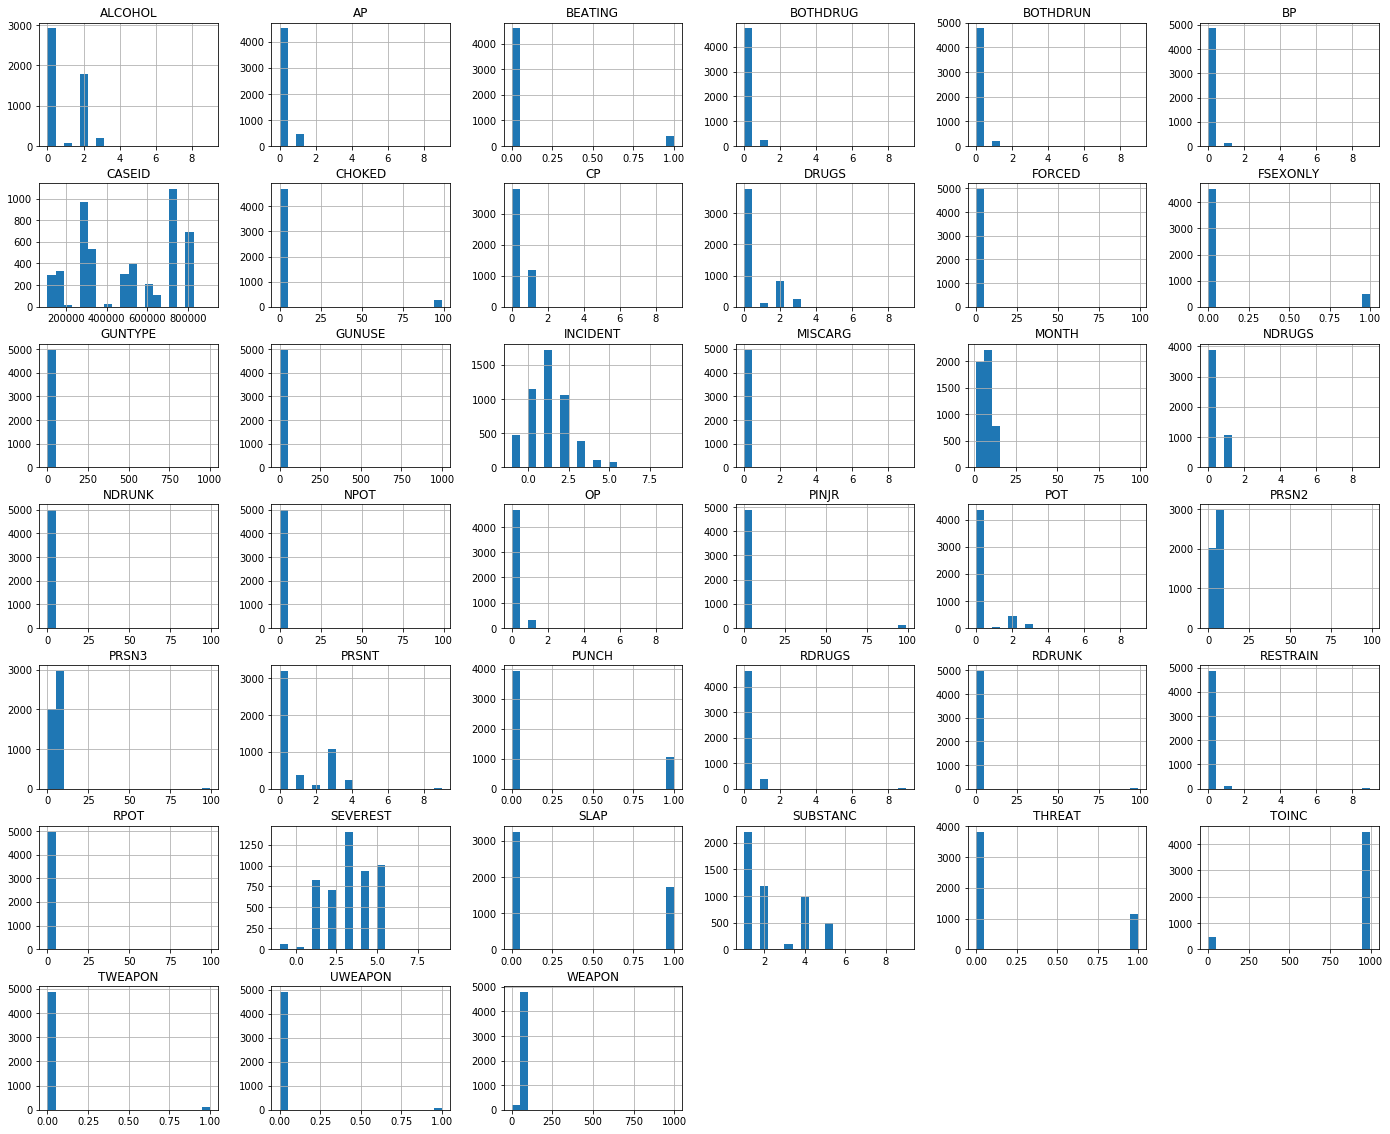

In [13]:
plot_hist(df)

### _Trying to see if we could use CHOKED as the target variable_

- 74 were choked
- 4,615 were not choked
- 9 and 999 are unknowns

In [14]:
count_values('CHOKED')

0     4615
99     285
1       74
9        4
Name: CHOKED, dtype: int64

### _Trying to see if we could use TOINC (total # of incidents in a year) instead._

In [15]:
df['REASSAULT'] = np.where(df['TOINC']>=1, 1, 0)
df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CASEID,108395,108397,108397,108399,108399,108443,108444,108444,108444,108444,108444,108456,108456,108456,108460
INCIDENT,2,1,4,1,3,3,1,1,1,1,1,2,0,0,2
FORCED,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MONTH,12,6,1,1,1,6,3,4,4,4,1,5,10,2,8
WEAPON,99,99,2,99,99,99,99,99,99,99,99,99,99,99,99
GUNTYPE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GUNUSE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
THREAT,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
SLAP,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0
PUNCH,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


### _Nope! All cases (respondents) were assaulted multiple times!_

In [16]:
count_values('REASSAULT')

1    4978
Name: REASSAULT, dtype: int64

In [17]:
df.drop(columns=['REASSAULT'], inplace=True)

### _What's the number of unique survivors out of 4,978 incidents?_

In [18]:
len(df['CASEID'].unique().tolist())

497

### _It looks like CHOKED is the best variable to predict. However, we need to fix the imbalance first. We have three options:_

0. undersample
0. oversample
0. use an ensemble method

Here is an article that discusses the handling of imbalanced dataset: https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

To fix the imbalance, we can use the `BalancedBaggingClassifier` from the **imblearn** library. Here's the link to the documentation: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html#imblearn.ensemble.BalancedBaggingClassifier

### _But, why CHOKED versus any other type of physical violence? Because, "non-fatal strangulation is an important risk factor for homicide of women"._

Here's a research article about the topic: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2573025/

## TRAIN / TEST SPLIT

In [20]:
df.shape

(4978, 39)

In [21]:
# x_columns = ['INCIDENT',
#              'TOINC',
#             ]

X = df.drop(columns=['CHOKED'])
y = df[['CHOKED']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [26]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Create an object of the classifier.
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(),
                                replacement=False,
                                random_state=0)

y_train = df['CHOKED']
X_train = df.drop(['CHOKED'], axis=1, inplace=False)

#Train the classifier.
bbc.fit(X_train, y_train)
preds = bbc.predict(X_train)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(bbc.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.76


In [29]:
print(classification_report(y_train, preds))

             precision    recall  f1-score   support

          0       0.94      0.80      0.87      4615
          1       0.03      0.15      0.05        74
          9       1.00      1.00      1.00         4
         99       0.10      0.24      0.14       285

avg / total       0.88      0.76      0.81      4978



## GRIDSEARCH OR XGBOOST ?

# MODELING

## OUT OF SAMPLE PERFORMANCE EVALUATION